##Import Libraries

In [5]:
# Library to support working with data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from functools import partial
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from functools import partial
from keras.layers import GRU, Dropout, Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_percentage_error

##Data preprocessing

###Read data

In [6]:
# Load data
df = pd.read_csv('./data/CTLT.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,30.860001,31.260000,30.240000,30.910000,30.910000,1201700
1,2019-01-03,30.660000,30.660000,29.290001,29.840000,29.840000,1149900
2,2019-01-04,30.049999,31.360001,29.940001,31.080000,31.080000,3530400
3,2019-01-07,31.020000,32.180000,30.850000,32.000000,32.000000,1063400
4,2019-01-08,32.340000,33.060001,32.150002,32.790001,32.790001,1391000
...,...,...,...,...,...,...,...
1114,2023-06-06,37.910000,39.049999,37.580002,38.820000,38.820000,2261700
1115,2023-06-07,39.160000,40.029999,38.250000,39.959999,39.959999,4382500
1116,2023-06-08,39.700001,39.840000,36.750000,39.000000,39.000000,9705500
1117,2023-06-09,39.250000,40.110001,38.480000,38.810001,38.810001,4493800


###Reset index

In [7]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [8]:
# Select the Close column as the dependent variable
df_Close = df[['Close']]
#df_Close = df_Close.dropna() # Drop missing values
df_Close = df_Close.reset_index(drop=True) # Reset the index
df_Close.head(20)

,Close
0,30.910000
1,29.840000
2,31.080000
3,32.000000
4,32.790001
5,33.380001
6,33.880001
7,33.750000
8,33.590000
9,34.070000


###Data normalization

In [9]:
# Scaling the data
scaler=MinMaxScaler(feature_range=(0,1))
data_scaled=scaler.fit_transform(df_Close)
data_scaled

array([[0.00951027],
       [0.        ],
       [0.01102124],
       ...,
       [0.08141498],
       [0.07972625],
       [0.11501198]])

###Data splitting

In [10]:
# Split the data into training, validation and test dataset in a ratio of 6:2:2
train_size = int(0.6 * len(data_scaled))
val_size = int(0.2 * len(data_scaled))
test_size = len(data_scaled) - train_size - val_size

train_data = data_scaled[: train_size]
val_data = data_scaled[train_size : train_size + val_size]
test_data = data_scaled[train_size + val_size :]

###Define Model and find the Best Model on the Training and Validation Sets

In [11]:
#define
units_values = [50, 100, 150, 200]
dropout_values = [0.1, 0.2, 0.3, 0.4, 0.5]
optimizer_values = ['adam', 'rmsprop', 'sgd']

#define param_distributions
param_distributions = {
    'units': units_values,
    'dropout': dropout_values,
    'optimizer': optimizer_values
}

#define time_step
time_step_grid = [30, 50, 60, 70, 100]


best_mape = float('inf')
best_model = None
best_params = None
best_time_step = None

In [12]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step, prev_data=None):
    dataX, dataY = [], []
    start_index = 0

    # If previous data is available
    if prev_data is not None:
        start_index = max(0, time_step - len(prev_data))
        dataset = np.concatenate((prev_data, dataset))

    for i in range(start_index, len(dataset)-time_step):
        dataX.append(dataset[i:(i+time_step), 0])
        dataY.append(dataset[i + time_step, 0])

    return np.array(dataX), np.array(dataY)


In [13]:
def create_model(time_step, units, dropout, optimizer):
    # Define GRU model with current parameters
    model = Sequential()
    model.add(GRU(units, input_shape=(time_step, 1)))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [14]:
for time_step in time_step_grid:
    print(f"Starting evaluation for time_step: {time_step}")

    X_train, y_train = create_dataset(train_data, time_step)
    last_points_train = train_data[-time_step:]
    X_val, y_val = create_dataset(val_data, time_step, last_points_train)


    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

    model = KerasRegressor(build_fn=create_model, time_step=time_step, epochs=100, batch_size=64, verbose=0)

    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions, n_iter=10, cv=3)
    random_search.fit(X_train, y_train)

    current_model = random_search.best_estimator_.model

    # early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    current_model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[early_stopping])

    predictions = current_model.predict(X_val)
    mape = mean_absolute_percentage_error(y_val, predictions)

    print(f"Validation MAPE for time_step {time_step}: {mape}")
    print(f"Best parameters for time_step {time_step}: {random_search.best_params_}")

    if mape < best_mape:
        best_mape = mape
        best_model = current_model
        best_params = random_search.best_params_
        best_time_step = time_step
# Print the best overall parameters and score.
print("---------------------------------------")
print(f"Best overall MAPE: {best_mape}")
print(f"Best overall parameters: {best_params}")
print(f"Best overall time_step: {best_time_step}")

Starting evaluation for time_step: 30
7/7 [==============================] - 0s 3ms/step
Validation MAPE for time_step 30: 0.032506857216117145
Best parameters for time_step 30: {'units': 200, 'optimizer': 'adam', 'dropout': 0.4}
Starting evaluation for time_step: 50
7/7 [==============================] - 0s 3ms/step
Validation MAPE for time_step 50: 0.03580593420395773
Best parameters for time_step 50: {'units': 200, 'optimizer': 'adam', 'dropout': 0.5}
Starting evaluation for time_step: 60
7/7 [==============================] - 0s 3ms/step
Validation MAPE for time_step 60: 0.031104367339793975
Best parameters for time_step 60: {'units': 200, 'optimizer': 'adam', 'dropout': 0.1}
Starting evaluation for time_step: 70
7/7 [==============================] - 0s 3ms/step
Validation MAPE for time_step 70: 0.028926414658612943
Best parameters for time_step 70: {'units': 100, 'optimizer': 'adam', 'dropout': 0.4}
Starting evaluation for time_step: 100
7/7 [==============================] - 0s 

###Trainning the model with the best parameters.

In [15]:
# Create training, validation and test datasets with the best time_step
X_train, y_train = create_dataset(train_data, best_time_step)
X_val, y_val = create_dataset(val_data, best_time_step)

last_points_val = val_data[-best_time_step:]
X_test, y_test = create_dataset(test_data, best_time_step, last_points_val)
# Reshape input to be [samples, time steps, features] which is required for GRU
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

###Training process

In [16]:
# Create a new model with the best parameters
best_model = create_model(best_time_step, best_params['units'], best_params['dropout'], best_params['optimizer'])

In [17]:
# Define early stopping
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

In [18]:
# Train the model with the full training data (train + validation)
best_model.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)), epochs=100, batch_size=64, verbose=1, callbacks=[early_stopping])

Epoch 1/100
11/11 [==============================] - 3s 10ms/step - loss: 0.0659
Epoch 2/100
11/11 [==============================] - 0s 10ms/step - loss: 0.0161
Epoch 3/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0080
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0047
Epoch 5/100
11/11 [==============================] - 0s 9ms/step - loss: 0.0040
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 0.0034
Epoch 7/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0028
Epoch 8/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0023
Epoch 9/100
11/11 [==============================] - 0s 7ms/step - loss: 0.0023
Epoch 10/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0019
Epoch 11/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0024
Epoch 12/100
11/11 [==============================] - 0s 6ms/step - loss: 0.0022
Epoch 13/100
11/11 [===============

In [19]:
# Now use this to make predictions
y_pred_test = best_model.predict(X_test)

8/8 [==============================] - 0s 3ms/step


###Testing process

In [20]:
# Invert scaling
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_test_inv = scaler.inverse_transform(y_pred_test)

In [21]:
test_MAPE = mean_absolute_percentage_error(y_test_inv, y_pred_test_inv)
test_RMSE = mean_squared_error(y_test_inv, y_pred_test_inv, squared=False)
test_MSLE = mean_squared_log_error(y_test_inv, y_pred_test_inv)
print('MAPE on the data test:', test_MAPE)
print('RMSE on the data test', test_RMSE)
print('MSLE on the data test', test_MSLE)

MAPE on the data test: 0.043741109669244
RMSE on the data test 3.662703694030489
MSLE on the data test 0.004227080830584766


##Predicting the next 30 days

In [22]:
# Convert the last `best_time_step` days of the test data into the appropriate shape for input to the model
x_input = test_data[-best_time_step:].reshape(1, -1, 1)

temp_input = list(x_input[0])

lst_output = []
i = 0
while(i < 30):
    if len(temp_input) > best_time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1, 1)
        y_pred = best_model.predict(x_input)
        print("{} day input {}".format(i, x_input))
        print("{} day output {}".format(i, y_pred))
        temp_input.append(y_pred[0][0])
        temp_input = temp_input[1:]
        lst_output.append(y_pred[0][0])
        i += 1
    else:
        x_input = np.array(temp_input, dtype=np.float32).reshape((1, len(temp_input), 1))
        y_pred = best_model.predict(x_input)
        print("{} day input {}".format(i, x_input))
        print("{} day output {}".format(i, y_pred))
        temp_input.append(y_pred[0][0])
        temp_input = temp_input[1:]
        lst_output.append(y_pred[0][0])
        i += 1


1/1 [==============================] - 0s 20ms/step
0 day input [[[0.17287353]
  [0.17429562]
  [0.20220424]
  [0.17536218]
  [0.18060616]
  [0.19936004]
  [0.21162564]
  [0.20211537]
  [0.2107368 ]
  [0.2211359 ]
  [0.23820102]
  [0.23295705]
  [0.33028173]
  [0.37098923]
  [0.36858943]
  [0.3747222 ]
  [0.36103454]
  [0.3618345 ]
  [0.36005685]
  [0.34885782]
  [0.37374452]
  [0.36912274]
  [0.345036  ]
  [0.3361479 ]
  [0.336059  ]
  [0.3389921 ]
  [0.33241487]
  [0.34112522]
  [0.34814683]
  [0.3675229 ]
  [0.39480934]
  [0.36885604]
  [0.33748108]
  [0.35507953]
  [0.35641277]
  [0.33845878]
  [0.31846055]
  [0.35970134]
  [0.35552388]
  [0.36761174]
  [0.33125943]
  [0.330104  ]
  [0.32832634]
  [0.30939472]
  [0.29152963]
  [0.3060172 ]
  [0.3348147 ]
  [0.3206826 ]
  [0.32948184]
  [0.30957246]
  [0.31881607]
  [0.29401827]
  [0.28806326]
  [0.28246376]
  [0.3120611 ]
  [0.33259267]
  [0.31641632]
  [0.30583948]
  [0.29748467]
  [0.14647587]
  [0.13856545]
  [0.10879034]
  [0.1

In [23]:
# Invert the scaling
lst_output = scaler.inverse_transform(np.array(lst_output).reshape(-1,1))

print('Predicted closing prices for the next 30 days:')
for i in range(30):
    print(f"{lst_output[i][0]}")

Predicted closing prices for the next 30 days:
41.188499450683594
41.77357482910156
42.20991897583008
42.59650802612305
42.9620246887207
43.31694793701172
43.66603469848633
44.011783599853516
44.355587005615234
44.69828796386719
45.040374755859375
45.38215255737305
45.72381591796875
46.06548309326172
46.4072265625
46.74909973144531
47.091129302978516
47.43333435058594
47.77572250366211
48.118309020996094
48.46108627319336
48.80406951904297
49.14724349975586
49.49061965942383
49.83418273925781
50.17793655395508
50.521881103515625
50.86600875854492
51.21031951904297
51.55480194091797


##Visualization

In [24]:
# Create a date index for the predicted data
predict_data_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=30)

In [25]:
# Before Plotting Data
# Create index for the training, validation and test data
train_data_index = df.index[:train_size]
val_data_index = df.index[train_size : train_size + val_size]
test_data_index = df.index[train_size + val_size:]

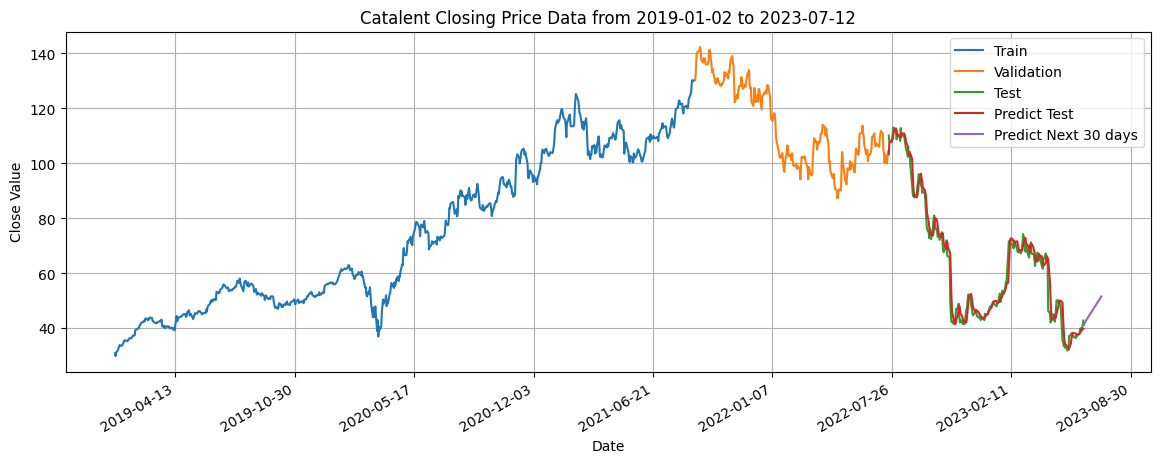

In [26]:
# Begin Plotting Data
plt.figure(figsize=(14, 5))
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')
plt.plot(val_data_index, scaler.inverse_transform(val_data), label='Validation')
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')
plt.plot(test_data_index, y_pred_test_inv, label='Predict Test')
plt.plot(predict_data_index, lst_output, label='Predict Next 30 days')

# Set up the date markers on the x-axis
plt.grid()
plt.title(f"Catalent Closing Price Data from {train_data_index[0].strftime('%Y-%m-%d')} to {predict_data_index[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close Value")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=200)) # Select markers spaced 200 days apart
plt.gcf().autofmt_xdate() # Rotate date labels for better readability
plt.legend()
plt.savefig('./GRU/6_2_2/Image/GRU_622_CTLT.png')
plt.show()
